In [1]:
import pandas as pd
import numpy as np
import datetime


In [2]:
train = pd.read_csv('./output/train.csv')    
test = pd.read_csv('./output/test.csv')    
test2 = pd.read_csv('./output/test2.csv')

def within_measure(x, y):
    #  3750901.5068 ≤ 𝑥 ≤ 3770901.5068
    #  −19268905.6133 ≤ 𝑦 ≤ −19208905.6133
    if 3750901.5068 <= x and x <= 3770901.5068 and -19268905.6133 <= y and y <= -19208905.6133:
        return 1
    else:
        return 0

train = train.append(test[test.x_exit==test.x_exit])
cols=['hash','trajectory_id','x_exit','y_exit',
      'distance_to_city'
     ]   
x_train = train.drop(columns=cols)
x_test = test2.drop(columns=cols)



y_train=pd.DataFrame()

y_train['x_exit']=train['x_exit']
y_train['y_exit']=train['y_exit']

In [3]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983684 entries, 0 to 202935
Data columns (total 2 columns):
x_exit    983684 non-null float64
y_exit    983684 non-null float64
dtypes: float64(2)
memory usage: 22.5 MB


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 983684 entries, 0 to 202935
Data columns (total 28 columns):
hash                983684 non-null object
trajectory_id       983684 non-null object
time_entry          983684 non-null int64
time_exit           983684 non-null int64
vmax                983684 non-null float64
vmin                983684 non-null float64
vmean               983684 non-null float64
x_entry             983684 non-null float64
y_entry             983684 non-null float64
x_exit              983684 non-null float64
y_exit              983684 non-null float64
first               983684 non-null bool
last                983684 non-null bool
x_req               983684 non-null float64
y_req               983684 non-null float64
x_start             983684 non-null float64
y_start             983684 non-null float64
distance            983684 non-null float64
time_start          983684 non-null int64
time_delta          983684 non-null int64
time_total          98368

In [5]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import matplotlib.patches as patches

_min_samples=35
_eps=300

columns=['x_entry','y_entry',
         #'distance_to_city',
        #'distance',
        # 'vmax','vmean','vmin',
        ]
data=train[columns]
trainend=np.shape(data)[0]
#data=data.append(test[columns])
#testend=np.shape(data)[0]
data=data.append(test2[columns])

c = DBSCAN(eps=_eps,min_samples=_min_samples,n_jobs=-1).fit_predict(data)
#c=MiniBatchKMeans(n_clusters=100,max_iter=100, batch_size=100,reassignment_ratio=0.2, verbose=True,random_state=5315).fit_predict(data)

labels=list(np.unique(c))
clusters=len(labels)
train_c=c[:trainend]
#test_c=c[trainend:testend]
test2_c=c[trainend:]
x_train['cluster']=train_c
x_test['cluster']=test2_c

clusters




1128

C:\Users\J.K. Pawłowski\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


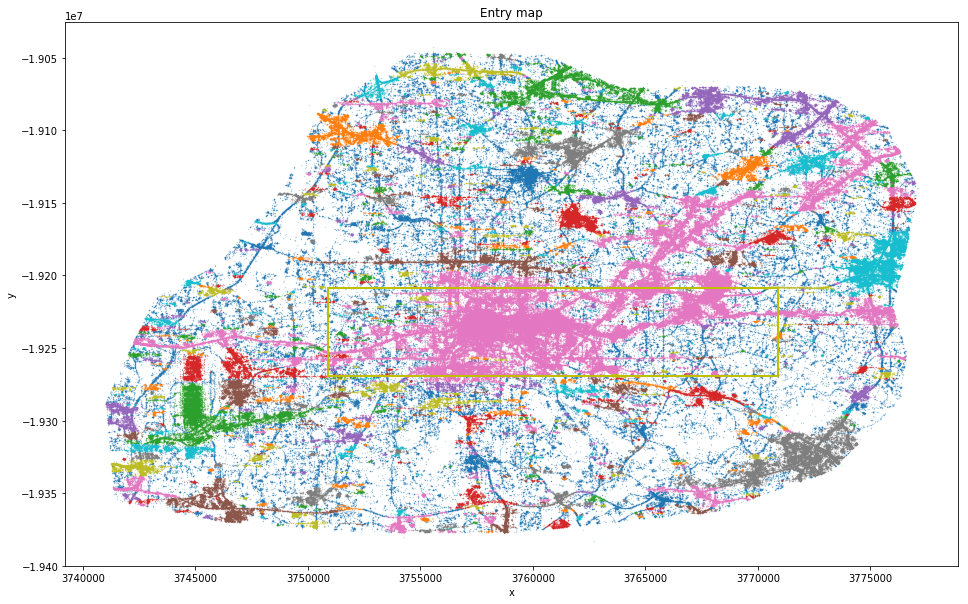

In [6]:
data=train[['x_entry','y_entry']]
data['c']=train_c

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(16)

# Plot
for c in labels:
    ax.scatter(data[data.c==c].x_entry.values,data[data.c==c].y_entry.values,s=.05, alpha=0.5)
    
# Create a Rectangle patch
rect = patches.Rectangle((3750901.5068,-19268905.6133),3770901.5068-3750901.5068,19268905.6133-19208905.6133,linewidth=2,edgecolor='y',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)    

ax.set(xlabel='x', ylabel='y',
       title='Entry map')

plt.show()


In [7]:
import lightgbm as lgb

params = {
    'objective' :'regression',
    'learning_rate' : 0.1,
    'num_boost_round':800,
    'num_leaves' : 1000,
    #'max_depth':4,
    #'feature_fraction': 0.64, 
    #'bagging_fraction': 0.8, 
    #'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': 'l2',
    'seed':213715153,  
    'num_threads':8
    }

devide_clusters = False

def naklastry(unnown):
    pred = pd.DataFrame({'c':test2_c,'target':test2_c})

    for c in labels:
        xc_train=x_train[train_c==c]
        yc_train=y_train[train_c==c][unnown].values
        xc_test=x_test[test2_c==c]
        if len(xc_test)==0:
            continue
        print(len(xc_train),len(xc_test))
        d_train = lgb.Dataset(xc_train, label=yc_train)
        clf = lgb.train(params, d_train)
        
        #Prediction
        def add(row,c):
            if row['c']==c:
                return target.pop(0)
            else:
                return row.target
            
        target=list(clf.predict(xc_test))
        pred['target'] = pred.apply(lambda x: add(x,c), axis=1)
                 
        print('done:',c)
    return pred.target.values

def jedna(unnown, t = False):
    
    d_train = lgb.Dataset(x_train, label=y_train[unnown].values)
    clf = lgb.train(params, d_train)
    #Prediction
    
    target=list(clf.predict(x_test))
    if t==True:
        target2=list(clf.predict(x_train))
        return target, target2

    return target
  
        
city_lgbm_c=pd.DataFrame()
city_lgbm=pd.DataFrame()
for col in ['x_exit','y_exit']:
    if devide_clusters:
        city_lgbm_c[col]=naklastry(unnown=col)   
    city_lgbm[col]=jedna(unnown=col,t=False)   

D:\Anaconda\lib\site-packages\lightgbm\engine.py:113: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [8]:
import statistics
X = test2['x_entry'].values 
Y = test2['y_entry'].values

def score(x):
    if x>=0.5:
        return 1
    else:
        return 0


city_sqrt = [within_measure(x, y) for x,y in zip(X,Y)]
city_lgbm['target'] = [within_measure(x, y) for x,y in zip(city_lgbm.x_exit.values,city_lgbm.y_exit.values)]

if devide_clusters:
    city_lgbm_c['target'] = [within_measure(x, y) for x,y in zip(city_lgbm_c.x_exit.values,city_lgbm_c.y_exit.values)]

    city=pd.DataFrame()
    for col in ['x_exit','y_exit']:
        city[col]=(city_lgbm_c[col]+city_lgbm[col])/2
    city['target'] = [within_measure(x, y) for x,y in zip(city.x_exit.values,city.y_exit.values)]


In [9]:



#city = [score(statistics.mean(k)) for k in zip(city_lgbm_c.target.values,city_lgbm.target.values)]



submission= pd.DataFrame()
trajectory_id = test2['trajectory_id']
submission['id']=trajectory_id 
submission['target'] = city_lgbm.target
submission.to_csv('./output/regress/lgbm.csv',index=False)    

if devide_clusters:

    submission['target'] = city_lgbm_c.target
    submission.to_csv('./output/regress/lgbm_c.csv',index=False)    

    submission['target'] = city.target.values
    submission.to_csv('./output/regress/city.csv',index=False)    

In [10]:
def plotmap(ycity,title):
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(16)

    df=test2[['x_entry','y_entry']]
    df['sqrt']=city_sqrt
    df['target']=ycity
    df=df[df.sqrt==0]
    leg=['Outside','City']
    # Plot
    for data in [df[df.target==1]]:
        ax.scatter(data.x_entry.values, data.y_entry.values,c='r',s=10, alpha=0.5,label=leg.pop(0))

    # Create a Rectangle patch
    rect = patches.Rectangle((3750901.5068,-19268905.6133),3770901.5068-3750901.5068,19268905.6133-19208905.6133,linewidth=2,edgecolor='y',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)    

    ax.set(xlabel='x', ylabel='y',
           title=title)
    ax.legend(loc="upper left", markerscale=2, scatterpoints=1, fontsize=10)
    plt.show()

C:\Users\J.K. Pawłowski\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\J.K. Pawłowski\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


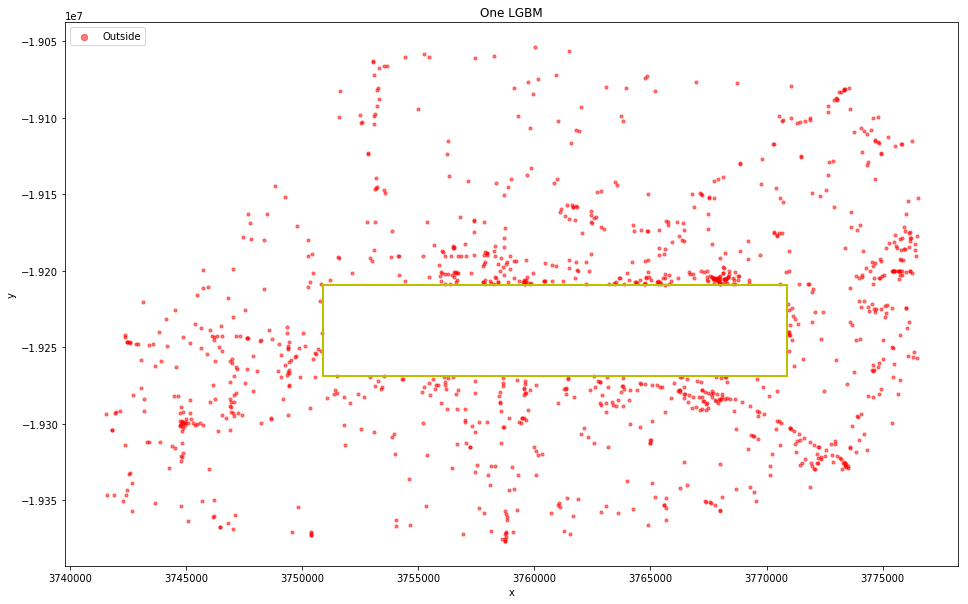

In [11]:
plotmap(city_lgbm.target.values,'One LGBM')

In [12]:
if devide_clusters:
    plotmap(city_lgbm_c.target.values,'Clusters LGBM')

In [13]:
if devide_clusters:
    plotmap(city.target.values,'Submission outside the sqrt')